In [1]:
import jupyros as jr
import rospy
import numpy as np
from sensor_msgs import msg
import cv2
import cv_bridge
from copy import deepcopy
import ipywidgets as widgets
import PIL.Image
from cStringIO import StringIO
import matplotlib.pyplot as plt
import dvrk
import PyKDL
import tf
import time
from tf_conversions import posemath
import utils

In [2]:
rospy.init_node('notebook')
rospy.get_published_topics()

[['/dvrk/setup_joint/robot_state', 'std_msgs/String'],
 ['/dvrk/PSM1/current_state', 'std_msgs/String'],
 ['/dvrk/ECM/wrench_body_current', 'geometry_msgs/WrenchStamped'],
 ['/dvrk/ECM/set_effort_joint', 'sensor_msgs/JointState'],
 ['/stereo/right/image_flipped', 'sensor_msgs/Image'],
 ['/dvrk/PSM3/goal_reached', 'std_msgs/Bool'],
 ['/dvrk/PSM2/position_cartesian_local_current', 'geometry_msgs/PoseStamped'],
 ['/dvrk/PSM1/set_position_goal_cartesian', 'geometry_msgs/Pose'],
 ['/dvrk/console/teleop/scale', 'std_msgs/Float32'],
 ['/dvrk/PSM3/state_joint_current', 'sensor_msgs/JointState'],
 ['/dvrk/console/teleop/teleop_psm_selected', 'diagnostic_msgs/KeyValue'],
 ['/dvrk/ECM/set_desired_state', 'std_msgs/String'],
 ['/dvrk/PSM2/joint_velocity_ratio', 'std_msgs/Float64'],
 ['/dvrk/PSM3/current_state', 'std_msgs/String'],
 ['/dvrk/PSM3/manip_clutch', 'std_msgs/Bool'],
 ['/dvrk/PSM3/position_cartesian_current', 'geometry_msgs/PoseStamped'],
 ['/dvrk/PSM1/set_position_jaw', 'sensor_msgs/Joi

In [3]:
bridge = cv_bridge.CvBridge()
left_image = None
left_image_msg = None
left_camera_info = None

right_image = None
right_image_msg = None
right_camera_info = None

def left_image_callback(im_msg):
    global left_image, left_image_msg
    left_image = bridge.imgmsg_to_cv2(im_msg, desired_encoding='rgb8')
    left_image_msg = im_msg
    
def right_image_callback(im_msg):
    global right_image, right_image_msg
    right_image = bridge.imgmsg_to_cv2(im_msg, desired_encoding='rgb8')
    right_image_msg = im_msg
    
def left_camera_info_callback(camera_info_msg):
    global left_camera_info
    left_camera_info = camera_info_msg
    
def right_camera_info_callback(camera_info_msg):
    global right_camera_info
    right_camera_info = camera_info_msg
    
jr.subscribe('/stereo/left/image_raw', msg.Image, left_image_callback)
jr.subscribe('/stereo/left/camera_info', msg.CameraInfo, left_camera_info_callback)
jr.subscribe('/stereo/right/image_raw', msg.Image, right_image_callback)
jr.subscribe('/stereo/right/camera_info', msg.CameraInfo, right_camera_info_callback)

while left_image is None or right_image is None:
    time.sleep(0.5)

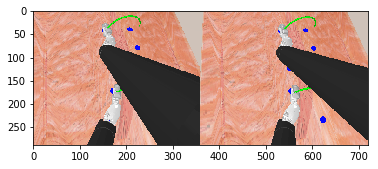

In [4]:
plt.imshow(np.hstack((left_image, right_image)))

In [5]:
tf_listener = tf.TransformListener()
time.sleep(1)
tf_listener.getFrameStrings()

/opt/ros/melodic/lib/python2.7/dist-packages/tf/listener.py:97: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(self._buffer.all_frames_as_yaml()) or {}


['PSM2_tool_wrist_shaft_link',
 'PSM2_outer_pitch_front_link',
 'PSM2_tool_main_link',
 'PSM2_tool_wrist_caudier_link_2_left',
 'PSM1',
 'PSM2',
 'PSM3',
 'PSM2_tool_wrist_caudier_ee_link',
 'PSM1_tool_wrist_sca_ee_link_1',
 'PSM1_tool_wrist_sca_ee_link_2',
 'ecm_setup_link',
 'ecm_yaw_link',
 'PSM2_tool_wrist_caudier_link_shaft',
 'PSM1_tool_wrist_sca_ee_link_0',
 'ECM',
 'PSM1_outer_pitch_link',
 'PSM2_outer_pitch_link',
 'PSM1_tool_tip_link',
 'camera',
 'PSM1_outer_pitch_front_link',
 'ecm_pitch_link',
 'PSM2_tool_wrist_caudier_link',
 'PSM1_outer_yaw_link',
 'ecm_insertion_link',
 'ecm_roll_link',
 'ecm_pitch_link_2',
 'ecm_pitch_link_3',
 'PSM1_tool_wrist_shaft_link',
 'PSM2_outer_pitch_back_link',
 'PSM1_tool_wrist_sca_link',
 'PSM2_outer_pitch_top_link',
 'simcamera',
 'PSM2_tool_wrist_caudier_ee_link_0',
 'PSM1_outer_insertion_link',
 'PSM2_outer_pitch_bottom_link',
 'PSM1_outer_pitch_top_link',
 'PSM1_outer_pitch_bottom_link',
 'PSM2_tool_wrist_caudier_link_2_right',
 'ecm_ba

In [6]:
psm1 = dvrk.psm('PSM1')
psm2 = dvrk.psm('PSM2')
ecm = dvrk.ecm('ECM')
while ecm.get_current_position() == PyKDL.Frame() or ecm.get_desired_position() == PyKDL.Frame():
    time.sleep(0.5)
while psm1.get_current_position() == PyKDL.Frame() or psm1.get_desired_position() == PyKDL.Frame():
    time.sleep(0.5)

In [7]:
# ECM_STARTING_JOINT_POS = np.asarray([-0.15669435,  0.17855662,  0.07069676,  0.17411496])
# ECM_STARTING_JOINT_POS = np.asarray([0.0615668 , 0.0523214 , 0.04854392, 0.15809197])
ECM_STARTING_JOINT_POS = np.asarray([-0.14478268, -0.1293848 ,  0.00261061,  0.043541  ])
ecm.move_joint(ECM_STARTING_JOINT_POS)

In [8]:
time.sleep(1)
PSM_HOME_POS = np.asarray([0., 0., 0.05, 0., 0., 0.])
psm1.move_joint(PSM_HOME_POS)
psm1.close_jaw()

psm2.move_joint(PSM_HOME_POS)
psm2.close_jaw()

True

[ 0.0028     -0.019       0.06239207]
[      0.0028,      -0.019,   0.0623921]
[-0.01229167 -0.01833333  0.06499174]
[  -0.0122917,  -0.0183333,   0.0649917]
[ 0.00181818 -0.00613636  0.07090008]
[  0.00181818, -0.00613636,   0.0709001]
[-0.01428571 -0.0052381   0.07427627]
[  -0.0142857,  -0.0052381,   0.0742763]
[0.00238095 0.00547619 0.07427627]
[  0.00238095,  0.00547619,   0.0742763]
[-0.0135      0.0065      0.07799009]
[     -0.0135,      0.0065,   0.0779901]
[0.0045     0.01525    0.07799009]
[      0.0045,     0.01525,   0.0779901]
[-0.01157895  0.01736842  0.08209483]
[  -0.0115789,   0.0173684,   0.0820948]
[0.00710526 0.02710526 0.08209483]
[  0.00710526,   0.0271053,   0.0820948]
[-0.00823529  0.03088235  0.09175304]
[ -0.00823529,   0.0308824,    0.091753]


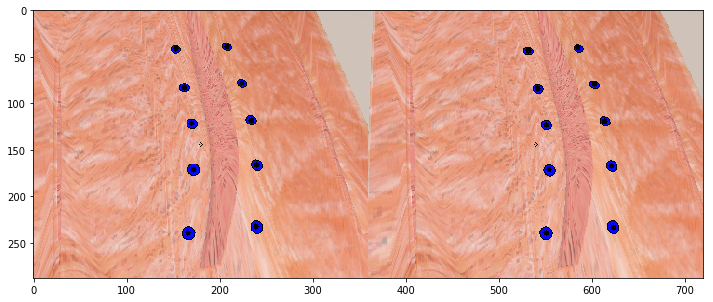

In [9]:
import image_geometry
utils = None
import utils
stereo_model = image_geometry.StereoCameraModel()
stereo_model.fromCameraInfo(left_camera_info, right_camera_info)

tf_cam_to_world = utils.tf_to_pykdl_frame(tf_listener.lookupTransform('simworld', 'simcamera', rospy.Time()))
tf_world_to_psm1 = \
    utils.PSM_J1_TO_BASE_LINK_TF * utils.tf_to_pykdl_frame(tf_listener.lookupTransform('J1_PSM1', 'simworld', rospy.Time()))
tf_world_to_psm2 = \
    utils.PSM_J1_TO_BASE_LINK_TF * utils.tf_to_pykdl_frame(tf_listener.lookupTransform('J1_PSM2', 'simworld', rospy.Time()))

objects, frame = utils.get_points_and_img(left_image_msg, right_image_msg, stereo_model, tf_cam_to_world)
plt.figure(figsize=(12, 5))
plt.imshow(frame)
for o in objects:
    o = PyKDL.Vector(o.x(), o.y(), o.z() - 0.005)

In [10]:
len(objects)

10

In [11]:
# pair up points that are across from each other
# x is *more or less* the axis along the wound
paired_pts = []
while objects:
    pt = objects[0]
    objects.remove(pt)
    pt2 = min(objects, key=lambda obj : abs(obj.x() - pt.x()))
    objects.remove(pt2)
    paired_pts.append(
        (max(pt, pt2, key=lambda p: p.y()), min(pt, pt2, key=lambda p: p.y())))
paired_pts

[([    -1.58025, -0.00450267,    0.725648],
  [     -1.5809,  -0.0198116,    0.725223]),
 ([    -1.56541, -0.00803435,    0.723174],
  [     -1.5657,  -0.0244843,    0.722248]),
 ([    -1.55345, -0.00910652,    0.724695],
  [    -1.55346,  -0.0254034,    0.723488]),
 ([     -1.5428, -0.00853246,    0.724999],
  [    -1.54169,  -0.0251888,    0.723897]),
 ([    -1.53003,  -0.0077375,    0.725729],
  [    -1.52517,  -0.0247159,    0.720159])]

In [12]:
import suturing_state_machine
reload(suturing_state_machine)
reload(utils)

sm1 = suturing_state_machine.SuturingStateMachine(psm1, tf_world_to_psm1, paired_pts[3:])  
sm2 = suturing_state_machine.SuturingStateMachine(psm2, tf_world_to_psm2, paired_pts[:3])

while not sm1.is_done() or not sm2.is_done():
    sm1.run_once()
    sm2.run_once()
    time.sleep(0.1)

[INFO] [1601850674.751643]: Executing state SuturingState.PREPARE_INSERTION
[INFO] [1601850674.754118]: Executing state SuturingState.PREPARE_INSERTION
[INFO] [1601850674.856089]: Distance from arm to dest: 0.0860620068645
[INFO] [1601850674.857226]: Executing state SuturingState.PREPARE_INSERTION
[INFO] [1601850674.858086]: Distance from arm to dest: 0.0742194997179
[INFO] [1601850674.858850]: Executing state SuturingState.PREPARE_INSERTION
[INFO] [1601850674.962470]: Distance from arm to dest: 0.0828592474653
[INFO] [1601850674.963786]: Executing state SuturingState.PREPARE_INSERTION
[INFO] [1601850674.965459]: Distance from arm to dest: 0.0708060624678
[INFO] [1601850674.967391]: Executing state SuturingState.PREPARE_INSERTION
[INFO] [1601850675.068943]: Distance from arm to dest: 0.077907898518
[INFO] [1601850675.070892]: Executing state SuturingState.PREPARE_INSERTION
[INFO] [1601850675.073660]: Distance from arm to dest: 0.06520996008
[INFO] [1601850675.075009]: Executing state S

[INFO] [1601850677.102408]: Executing state SuturingState.INSERTION
[INFO] [1601850677.105990]: Moving to pose 5 out of 17
[INFO] [1601850677.107036]: Executing state SuturingState.INSERTION
[INFO] [1601850677.108048]: Moving to pose 5 out of 17
[INFO] [1601850677.209108]: Executing state SuturingState.INSERTION
[INFO] [1601850677.210293]: Moving to pose 6 out of 17
[INFO] [1601850677.211080]: Executing state SuturingState.INSERTION
[INFO] [1601850677.211874]: Moving to pose 6 out of 17
[INFO] [1601850677.312869]: Executing state SuturingState.INSERTION
[INFO] [1601850677.316431]: Moving to pose 6 out of 17
[INFO] [1601850677.317362]: Executing state SuturingState.INSERTION
[INFO] [1601850677.318389]: Moving to pose 6 out of 17
[INFO] [1601850677.419313]: Executing state SuturingState.INSERTION
[INFO] [1601850677.421014]: Moving to pose 7 out of 17
[INFO] [1601850677.421996]: Executing state SuturingState.INSERTION
[INFO] [1601850677.423705]: Moving to pose 7 out of 17
[INFO] [16018506

[INFO] [1601850680.877398]: Distance from arm to dest: 0.01514587131
[INFO] [1601850680.878466]: Executing state SuturingState.OVERROTATE
circle_center=[    -1.55211,  -0.0184912,    0.739192], circle_radius=0.017
[INFO] [1601850680.879599]: Distance from arm to dest: 0.0232909901019
[INFO] [1601850680.880359]: Executing state SuturingState.OVERROTATE
circle_center=[    -1.58836,  -0.0122482,    0.740598], circle_radius=0.017
[INFO] [1601850680.981455]: Distance from arm to dest: 0.0125700468319
[INFO] [1601850680.982470]: Executing state SuturingState.OVERROTATE
circle_center=[    -1.55211,  -0.0184912,    0.739192], circle_radius=0.017
[INFO] [1601850680.983479]: Distance from arm to dest: 0.0198305750641
[INFO] [1601850680.984344]: Executing state SuturingState.OVERROTATE
circle_center=[    -1.58836,  -0.0122482,    0.740598], circle_radius=0.017
[INFO] [1601850681.087649]: Distance from arm to dest: 0.00846286602149
[INFO] [1601850681.089002]: Executing state SuturingState.OVERROTA

[INFO] [1601850683.195836]: Executing state SuturingState.EXTRACTION
[INFO] [1601850683.197111]: Moving to pose 7 out of 12
[INFO] [1601850683.200256]: Executing state SuturingState.EXTRACTION
[INFO] [1601850683.201243]: Moving to pose 5 out of 12
[INFO] [1601850683.302144]: Executing state SuturingState.EXTRACTION
[INFO] [1601850683.303307]: Moving to pose 7 out of 12
[INFO] [1601850683.304310]: Executing state SuturingState.EXTRACTION
[INFO] [1601850683.305051]: Moving to pose 5 out of 12
[INFO] [1601850683.405990]: Executing state SuturingState.EXTRACTION
[INFO] [1601850683.407482]: Moving to pose 8 out of 12
[INFO] [1601850683.408478]: Executing state SuturingState.EXTRACTION
[INFO] [1601850683.411215]: Moving to pose 6 out of 12
[INFO] [1601850683.512253]: Executing state SuturingState.EXTRACTION
[INFO] [1601850683.513323]: Moving to pose 8 out of 12
[INFO] [1601850683.514207]: Executing state SuturingState.EXTRACTION
[INFO] [1601850683.514973]: Moving to pose 6 out of 12
[INFO] [

[INFO] [1601850687.162754]: Executing state SuturingState.HOME
[INFO] [1601850687.164409]: Executing state SuturingState.HOME
[INFO] [1601850687.265708]: Executing state SuturingState.HOME
[INFO] [1601850687.266902]: Executing state SuturingState.HOME
[INFO] [1601850687.368776]: Executing state SuturingState.HOME
[INFO] [1601850687.370192]: Executing state SuturingState.HOME
[INFO] [1601850687.471345]: Executing state SuturingState.HOME
[INFO] [1601850687.472393]: Executing state SuturingState.HOME
[INFO] [1601850687.576470]: Executing state SuturingState.HOME
[INFO] [1601850687.577927]: Executing state SuturingState.HOME
[INFO] [1601850687.679111]: Executing state SuturingState.HOME
[INFO] [1601850687.680227]: Executing state SuturingState.HOME
[INFO] [1601850687.781323]: Executing state SuturingState.PREPARE_INSERTION
[INFO] [1601850687.782369]: Executing state SuturingState.HOME
[INFO] [1601850687.883365]: Distance from arm to dest: 0.0969499385955
[INFO] [1601850687.884294]: Execut

[INFO] [1601850689.888391]: Executing state SuturingState.INSERTION
[INFO] [1601850689.889555]: Moving to pose 4 out of 17
[INFO] [1601850689.890859]: Executing state SuturingState.INSERTION
[INFO] [1601850689.891825]: Moving to pose 2 out of 17
[INFO] [1601850689.992748]: Executing state SuturingState.INSERTION
[INFO] [1601850689.993838]: Moving to pose 5 out of 17
[INFO] [1601850689.994722]: Executing state SuturingState.INSERTION
[INFO] [1601850689.995602]: Moving to pose 2 out of 17
[INFO] [1601850690.096613]: Executing state SuturingState.INSERTION
[INFO] [1601850690.100063]: Moving to pose 5 out of 17
[INFO] [1601850690.100943]: Executing state SuturingState.INSERTION
[INFO] [1601850690.101757]: Moving to pose 3 out of 17
[INFO] [1601850690.202597]: Executing state SuturingState.INSERTION
[INFO] [1601850690.203730]: Moving to pose 6 out of 17
[INFO] [1601850690.204494]: Executing state SuturingState.INSERTION
[INFO] [1601850690.205262]: Moving to pose 3 out of 17
[INFO] [16018506

[ERROR] [1601850691.932078]: bad callback: <bound method psm.__state_joint_current_cb of <dvrk.psm.psm object at 0x7f35cc6ba190>>
Traceback (most recent call last):
  File "/opt/ros/melodic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/ubuntu/catkin_ws/src/dvrk-ros/dvrk_python/src/dvrk/arm.py", line 286, in __state_joint_current_cb
    self.__effort_joint_current.resize(len(data.effort))
ValueError: cannot resize an array that references or is referenced
by another array in this way.
Use the np.resize function or refcheck=False



[INFO] [1601850691.985577]: Executing state SuturingState.INSERTION
[INFO] [1601850691.986782]: Moving to pose 14 out of 17
[INFO] [1601850691.987809]: Executing state SuturingState.INSERTION
[INFO] [1601850691.990587]: Moving to pose 12 out of 17
[INFO] [1601850692.091569]: Executing state SuturingState.INSERTION
[INFO] [1601850692.092709]: Moving to pose 15 out of 17
[INFO] [1601850692.093488]: Executing state SuturingState.INSERTION
[INFO] [1601850692.094764]: Moving to pose 12 out of 17
[INFO] [1601850692.195779]: Executing state SuturingState.INSERTION
[INFO] [1601850692.196877]: Moving to pose 15 out of 17
[INFO] [1601850692.197642]: Executing state SuturingState.INSERTION
[INFO] [1601850692.198452]: Moving to pose 13 out of 17
[INFO] [1601850692.299438]: Executing state SuturingState.INSERTION
[INFO] [1601850692.302442]: Moving to pose 16 out of 17
[INFO] [1601850692.303312]: Executing state SuturingState.INSERTION
[INFO] [1601850692.304650]: Moving to pose 13 out of 17
[INFO] [

[INFO] [1601850694.927973]: Executing state SuturingState.GRASP_NEEDLE
[INFO] [1601850694.929088]: Distance from arm to dest: 0.0127439126249
[INFO] [1601850694.929881]: Executing state SuturingState.PREPARE_EXTRACTION
circle_center=[    -1.57355,  -0.0166081,    0.731408], circle_radius=0.012
[INFO] [1601850695.031084]: Executing state SuturingState.GRASP_NEEDLE
[INFO] [1601850695.032152]: Distance from arm to dest: 0.0101785761439
[INFO] [1601850695.032991]: Executing state SuturingState.PREPARE_EXTRACTION
circle_center=[    -1.57355,  -0.0166081,    0.731408], circle_radius=0.012
[INFO] [1601850695.134145]: Executing state SuturingState.GRASP_NEEDLE
[INFO] [1601850695.135465]: Distance from arm to dest: 0.00589337173833
[INFO] [1601850695.140123]: Executing state SuturingState.PREPARE_EXTRACTION
circle_center=[    -1.57355,  -0.0166081,    0.731408], circle_radius=0.012
[INFO] [1601850695.242239]: Executing state SuturingState.EXTRACTION
circle_center=[    -1.53433,  -0.0204306,    

[INFO] [1601850697.868761]: Executing state SuturingState.RELEASE_NEEDLE_2
[INFO] [1601850697.869924]: Executing state SuturingState.EXTRACTION
[INFO] [1601850697.870913]: Moving to pose 11 out of 12
[INFO] [1601850697.971771]: Executing state SuturingState.RELEASE_NEEDLE_2
[INFO] [1601850697.975316]: Executing state SuturingState.EXTRACTION
[INFO] [1601850697.976433]: Moving to pose 12 out of 12
[INFO] [1601850698.077571]: Executing state SuturingState.RELEASE_NEEDLE_2
[INFO] [1601850698.078844]: Executing state SuturingState.EXTRACTION
[INFO] [1601850698.079847]: Moving to pose 12 out of 12
[INFO] [1601850698.180869]: Executing state SuturingState.PICKUP
circle_center=[    -1.53433,  -0.0204306,    0.729887], circle_radius=0.012
[INFO] [1601850698.182038]: Executing state SuturingState.EXTRACTION
[INFO] [1601850698.182966]: Moving to pose 12 out of 12
[INFO] [1601850698.283844]: Distance from arm to dest: 0.0205003164983
[INFO] [1601850698.287295]: Executing state SuturingState.PICKU

[ERROR] [1601850698.588848]: bad callback: <bound method ecm.__state_joint_current_cb of <dvrk.ecm.ecm object at 0x7f35cc5fa9d0>>
Traceback (most recent call last):
  File "/opt/ros/melodic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/ubuntu/catkin_ws/src/dvrk-ros/dvrk_python/src/dvrk/arm.py", line 285, in __state_joint_current_cb
    self.__velocity_joint_current.resize(len(data.velocity))
ValueError: cannot resize an array that references or is referenced
by another array in this way.
Use the np.resize function or refcheck=False



[INFO] [1601850698.700647]: Distance from arm to dest: 0.0134261274615
[INFO] [1601850698.701747]: Executing state SuturingState.PICKUP
[INFO] [1601850698.702621]: Executing state SuturingState.RELEASE_NEEDLE_2
[INFO] [1601850698.803650]: Distance from arm to dest: 0.00939094780504
[INFO] [1601850698.804672]: Executing state SuturingState.PICKUP
[INFO] [1601850698.805515]: Executing state SuturingState.RELEASE_NEEDLE_2
[INFO] [1601850698.906544]: Distance from arm to dest: 0.00565276119303
[INFO] [1601850698.908295]: Executing state SuturingState.PICKUP
[INFO] [1601850698.911325]: Executing state SuturingState.PICKUP
circle_center=[    -1.57355,  -0.0166081,    0.731408], circle_radius=0.012
[INFO] [1601850699.012664]: Distance from arm to dest: 0.00243178288023
[INFO] [1601850699.013814]: Executing state SuturingState.GRASP_NEEDLE_2
[INFO] [1601850699.014687]: Distance from arm to dest: 0.0209477174254
[INFO] [1601850699.015364]: Executing state SuturingState.PICKUP
[INFO] [1601850699

[INFO] [1601850703.651387]: Executing state SuturingState.INSERTION
[INFO] [1601850703.652615]: Moving to pose 4 out of 17
[INFO] [1601850703.753857]: Executing state SuturingState.INSERTION
[INFO] [1601850703.754928]: Moving to pose 4 out of 17
[INFO] [1601850703.858434]: Executing state SuturingState.INSERTION
[INFO] [1601850703.859631]: Moving to pose 5 out of 17
[INFO] [1601850703.960835]: Executing state SuturingState.INSERTION
[INFO] [1601850703.962048]: Moving to pose 5 out of 17
[INFO] [1601850704.063170]: Executing state SuturingState.INSERTION
[INFO] [1601850704.064287]: Moving to pose 6 out of 17
[INFO] [1601850704.165292]: Executing state SuturingState.INSERTION
[INFO] [1601850704.166332]: Moving to pose 6 out of 17
[INFO] [1601850704.267433]: Executing state SuturingState.INSERTION
[INFO] [1601850704.271373]: Moving to pose 7 out of 17
[INFO] [1601850704.372543]: Executing state SuturingState.INSERTION
[INFO] [1601850704.374187]: Moving to pose 7 out of 17
[INFO] [16018507

[INFO] [1601850709.405869]: Executing state SuturingState.EXTRACTION
[INFO] [1601850709.407257]: Moving to pose 2 out of 12
[INFO] [1601850709.508795]: Executing state SuturingState.EXTRACTION
[INFO] [1601850709.511709]: Moving to pose 3 out of 12
[INFO] [1601850709.612757]: Executing state SuturingState.EXTRACTION
[INFO] [1601850709.614194]: Moving to pose 3 out of 12
[INFO] [1601850709.715166]: Executing state SuturingState.EXTRACTION
[INFO] [1601850709.716162]: Moving to pose 4 out of 12
[INFO] [1601850709.817384]: Executing state SuturingState.EXTRACTION
[INFO] [1601850709.818723]: Moving to pose 4 out of 12
[INFO] [1601850709.919889]: Executing state SuturingState.EXTRACTION
[INFO] [1601850709.920885]: Moving to pose 5 out of 12
[INFO] [1601850710.024664]: Executing state SuturingState.EXTRACTION
[INFO] [1601850710.026990]: Moving to pose 5 out of 12
[INFO] [1601850710.128384]: Executing state SuturingState.EXTRACTION
[INFO] [1601850710.129460]: Moving to pose 6 out of 12
[INFO] [

In [13]:
dir(psm1)

['__class__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__hash__',
 '__init__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_arm__arm_current_state',
 '_arm__arm_current_state_cb',
 '_arm__arm_current_state_event',
 '_arm__arm_desired_state',
 '_arm__arm_desired_state_cb',
 '_arm__arm_name',
 '_arm__check_input_type',
 '_arm__dmove_frame',
 '_arm__dmove_rotation',
 '_arm__dmove_translation',
 '_arm__effort_joint_current',
 '_arm__effort_joint_desired',
 '_arm__full_ros_namespace',
 '_arm__goal_reached',
 '_arm__goal_reached_cb',
 '_arm__goal_reached_event',
 '_arm__init_arm',
 '_arm__jacobian_body',
 '_arm__jacobian_body_cb',
 '_arm__jacobian_spatial',
 '_arm__jacobian_spatial_cb',
 '_arm__move_cartesian_direct',
 '_arm__move_cartesian_goal',
 '_arm__move_frame',
 '_arm__move_joint',
 '_arm__move_joint_direct',
 '_arm__move_joint_goal',
 '_

In [14]:
ecm.get_current_joint_position()

array([-0.14478268, -0.1293848 ,  0.00261061,  0.043541  ])

In [15]:
psm2.close_jaw()

True